<a href="https://colab.research.google.com/github/sasan73/Mangaka-Classifier/blob/master/Mangaka_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Mangaka** *Classifier*


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import torch
from torchvision import datasets, transforms, models
from torch.utils.data import random_split, DataLoader, Dataset
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import copy
import time

from PIL import Image
import matplotlib.pyplot as plt

# Data Loading 

In [ ]:
# folder = "Eiichiro Oda"
# file = "one-piece.csv"

In [ ]:
# folder = "Yoshihiro Togashi"
# file = "hunter-x-hunter.csv"

In [ ]:
# folder = "Hajime Isayama"
# file = "shingeki-no-kyojin.csv"

In [ ]:
# folder = "Koyoharu Gotouge"
# file = "kimetsu-no-yaiba.csv"

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
from pathlib import Path
path = Path('/content/drive/My Drive/Data/Mangaka Classification')

In [ ]:
# dest = path/folder
# dest.mkdir(parents=True, exist_ok=True)

In [ ]:
# path.ls()

In [ ]:
# download_images??

In [ ]:
# download_images(Path('/content/')/file, dest)

In [ ]:
# for c in classes:
    # print(c)
    # verify_images(path/c, delete=True, max_size=500)

(319, 158)


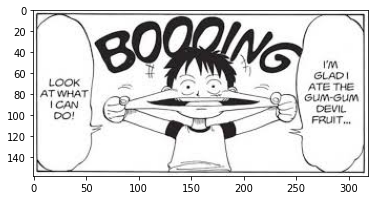

In [4]:
img = Image.open('/content/drive/My Drive/Data/Mangaka Classification/Eiichiro Oda/00000056.jpg')
plt.imshow(img)
print(img.size)

**Resnet Tranforms**

In [3]:
tfms_train = transforms.Compose([transforms.RandomResizedCrop(335),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

tfms_valid = transforms.Compose([transforms.Resize((335, 335)),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

**Costumnet Transforms**

In [5]:
tfms_train = transforms.Compose([transforms.RandomResizedCrop(335),
                                transforms.RandomHorizontalFlip(),
                                transforms.Grayscale(), 
                                transforms.ToTensor(),
                                transforms.Normalize(0, 1)])

tfms_valid = transforms.Compose([transforms.Resize((335, 335)),
                                 transforms.Grayscale(),
                                 transforms.ToTensor(),
                                 transforms.Normalize(0, 1)])

In [6]:
class Mydataset(Dataset):
  def __init__(self, subset, transforms = None):
    self.subset = subset
    self.transforms = transforms
  
  def __getitem__(self, indx):
    x, y = self.subset[indx]
    if self.transforms:  
      x = self.transforms(x)
    return x, y-1
  def __len__(self):
    return len(self.subset)

dataset = datasets.ImageFolder(path)

split_len = [int(len(dataset)* .8), int(len(dataset)* .2)]
train_sub, valid_sub = random_split(dataset, split_len)

train_ds = Mydataset(train_sub, transforms = tfms_train)
valid_ds = Mydataset(valid_sub, transforms = tfms_valid)

In [7]:
batch = 64

In [8]:
train_dl = DataLoader(train_ds, batch_size = batch, shuffle = False, num_workers = 4)
valid_dl = DataLoader(valid_ds, batch_size = batch, shuffle = False, num_workers = 4)

In [39]:
x, y = next(iter(train_dl))
x[0].shape

torch.Size([3, 335, 335])

# Data Visualisation

In [35]:
classes = ['One Piece', 'Attack on Titans', 'Demon Slayer', 'Hunter x Hunter']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


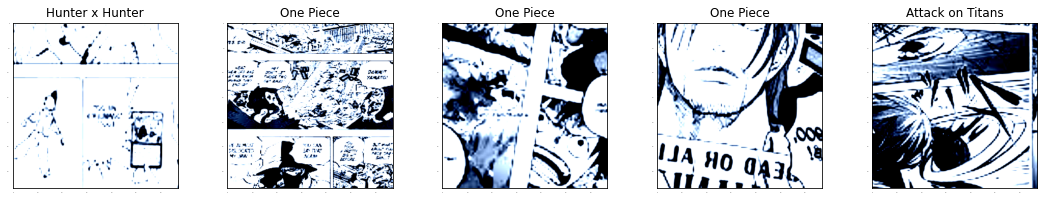

In [46]:
# still can be improved
def show_complete_batch(dl, num):
  img, label = next(iter(dl))
  k = 0
  fig, ax = plt.subplots(1, num, figsize = (15, 30))
  fig.tight_layout()
  plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)# setting margin between subplots to 0
  for i in range(num):
      ax[i].imshow(img[i].permute(1, 2, 0), cmap = 'bone')# 1.if images have three channels use .permute(1, 2, 0)
                                                          # 2.cmap = 'bone' argument added for better depiction of grayscaled images 
      ax[i].tick_params(axis='both', which='both',length=0 ,labelsize = 0) # remove ticks and tick labels
      ax[i].set_title(classes[label[i].item()])

show_complete_batch(train_dl, 5)

# Training Process

Defining the model. A model with arbitrary architecture constructed by resblocks.

In [45]:
def conv_layer(in_c, out_c, k, stride=1): return nn.Sequential(nn.Conv2d(in_c, out_c, k, stride, padding=1),
                                          nn.ReLU(),
                                          nn.BatchNorm2d(out_c))

class res_block(nn.Module):
   def __init__(self, c, k):
     super().__init__()
     self.conv1 = conv_layer(c, c, k)
     self.conv2 = conv_layer(c, c, k)
   def forward(self, x): 
     return x + self.conv2(self.conv1(x))

class global_avpool(nn.Module):
  def __init__(self):
    super().__init__()
  def forward(self, x): 
    num_dim = len(x.shape)
    return x.mean([num_dim - 1, num_dim - 2])

In [46]:
manga_net = nn.Sequential(conv_layer(1, 64, 5, stride = 2),
                          res_block(64, 3),
                          nn.MaxPool2d(2),
                          conv_layer(64, 128, 3, stride= 2),
                          nn.MaxPool2d(2),
                          res_block(128, 3),
                          global_avpool(),
                          nn.Linear(128, 4))

In [47]:
net = manga_net.cuda()

In [48]:
lr = 1e-2
EPOCH = 6
i = 0
momentum = 0.9 # find a way to implement momentum

In [50]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, 3, gamma = 0.1)

In [51]:
for epoch in range(EPOCH):  # loop over the dataset multiple times
    net.train()
    k = 0
    running_loss_train = 0.0
    for i, (inputs, labels) in enumerate(train_dl):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = inputs.cuda(), labels.cuda() 


        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss_train = criterion(outputs, labels)
        loss_train.backward()
        optimizer.step()

        running_loss_train += loss_train.item()
        k += 1
    print(f'epoch:{epoch}\t\t training_loss: {running_loss_train/ k}')
    
    
    net.eval()
    k = 0     
    running_loss_valid = 0
    corr_cls = 0
    for j, (inputs, labels)  in enumerate(valid_dl):
        with torch.no_grad():
          inputs, labels = inputs.cuda(), labels.cuda()
          outputs = net(inputs)
          loss_valid = criterion(outputs, labels) 
          # calculating evaluation stats
          running_loss_valid += loss_valid.item()
          k += 1
          
          _, preds = torch.max(F.softmax(outputs, 1), 1)
          corr_cls += (preds == labels).sum().item()
                
    print(f'epoch:{epoch}\t\t validation_loss: {running_loss_valid/ k}')
    print(f'epoch:{epoch}\t\t accuracy:{corr_cls * 100 /len(valid_ds)}')   
    print('-' * 20)
    scheduler.step
print('Finished Training')

epoch:0		 training_loss: 1.3286837276659513
epoch:0		 validation_loss: 7.825929927825928
epoch:0		 accuracy:38.095238095238095
--------------------
epoch:1		 training_loss: 1.1343092949766862
epoch:1		 validation_loss: 1.324607014656067
epoch:1		 accuracy:46.59863945578231
--------------------
epoch:2		 training_loss: 1.0927496458354748
epoch:2		 validation_loss: 1.1392229080200196
epoch:2		 accuracy:51.70068027210884
--------------------
epoch:3		 training_loss: 1.0975417996707715
epoch:3		 validation_loss: 1.0550811529159545
epoch:3		 accuracy:58.843537414965986
--------------------
epoch:4		 training_loss: 1.0559044072502537
epoch:4		 validation_loss: 1.170577085018158
epoch:4		 accuracy:53.40136054421769
--------------------
epoch:5		 training_loss: 1.0401988154963444
epoch:5		 validation_loss: 1.0316343784332276
epoch:5		 accuracy:57.142857142857146
--------------------
Finished Training


In [ ]:
PATH = '/content/drive/My Drive/Data/Mangaka Classification/models/stage1.pth'
torch.save(net.state_dict(), PATH)

In [ ]:
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
torch.cuda.empty_cache()

# defining a function for model

In [ ]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
#     since = time.time()

#     best_model_wts = copy.deepcopy(model.state_dict())
#     best_acc = 0.0

#     for epoch in range(num_epochs):
#         print('Epoch {}/{}'.format(epoch, num_epochs - 1))
#         print('-' * 10)

#         # Each epoch has a training and validation phase
#         for phase in ['train', 'val']:
#             if phase == 'train':
#                 model.train()  # Set model to training mode
#                 dataloaders = train_dl
#             else:
#                 model.eval()   # Set model to evaluate mode
#                 dataloaders = valid_dl

#             running_loss = 0.0
#             running_corrects = 0

#             # Iterate over data.
#             for inputs, labels in dataloaders:
#                 inputs = inputs.to(device)
#                 labels = labels.to(device)

#                 # zero the parameter gradients
#                 optimizer.zero_grad()

#                 # forward
#                 # track history if only in train
#                 with torch.set_grad_enabled(phase == 'train'):
#                     outputs = model(inputs)
#                     _, preds = torch.max(outputs, 1)
#                     loss = criterion(outputs, labels)

#                     # backward + optimize only if in training phase
#                     if phase == 'train':
#                         loss.backward()
#                         optimizer.step()

#                 # statistics
#                 running_loss += loss.item() * inputs.size(0)
#                 running_corrects += torch.sum(preds == labels.data)
#             if phase == 'train':
#                 scheduler.step()

#             if phase == 'train':
#                 epoch_loss = running_loss / len(train_ds) 
#                 epoch_acc = running_corrects.double() / len(train_ds)
#             else:
#                 epoch_loss = running_loss / len(valid_ds) 
#                 epoch_acc = running_corrects.double() / len(valid_ds)

#             print('{} Loss: {:.4f} Acc: {:.4f}'.format(
#                 phase, epoch_loss, epoch_acc))

#             # deep copy the model
#             if phase == 'val' and epoch_acc > best_acc:
#                 best_acc = epoch_acc
#                 best_model_wts = copy.deepcopy(model.state_dict())

#         print()

#     time_elapsed = time.time() - since
#     print('Training complete in {:.0f}m {:.0f}s'.format(
#         time_elapsed // 60, time_elapsed % 60))
#     print('Best val Acc: {:4f}'.format(best_acc))

#     # load best model weights
#     model.load_state_dict(best_model_wts)
#     return model

In [ ]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

train_model(net, criterion, optimizer, exp_lr_scheduler, num_epochs=5);

Epoch 0/4
----------
train Loss: 0.6752 Acc: 0.7355
val Loss: 0.7212 Acc: 0.7517

Epoch 1/4
----------
train Loss: 0.6462 Acc: 0.7330
val Loss: 1.0476 Acc: 0.6497

Epoch 2/4
----------
train Loss: 0.6525 Acc: 0.7355
val Loss: 0.7227 Acc: 0.7517

Epoch 3/4
----------
train Loss: 0.6613 Acc: 0.7500
val Loss: 1.1662 Acc: 0.5714

Epoch 4/4
----------
train Loss: 0.6527 Acc: 0.7313
val Loss: 1.0157 Acc: 0.6429

Training complete in 0m 25s
Best val Acc: 0.751701


# Resnet
In order to use the resnet model I need to redefine my datasets with three input channels(*red*, *green*, *blue*).

In [10]:
if torch.cuda.is_available():
  device = 'cuda:0'
else:
  device = 'cpu'

In [11]:
EPOCH = 10
resnet34 = models.resnet34(pretrained= True)
model = resnet34.to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001)
loss_fn = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=int(EPOCH / 3), gamma = 0.1)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [14]:
start = time.time()
for epoch in range(EPOCH):

  model.train()
  running_loss =  0
  print('Epochs: {0} out of {1} epochs'.format(epoch, EPOCH))
  print('-' * 10)
  for i, (inputs, labels) in enumerate(train_dl):
    inputs, labels= inputs.to(device), labels.to(device)
    outputs = model(inputs)
    optimizer.zero_grad()
    loss = loss_fn(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  print('batch training loss:{0:.2f}'.format(running_loss / i))
  running_loss = 0  # preparing running loss for validation
  
  model.eval()
  num_corr = 0
  num_total = 0
  for j, (inputs, labels) in enumerate(valid_dl):
    with torch.no_grad():
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      loss = loss_fn(outputs, labels)
      running_loss += loss.item()
      _, preds = torch.max(outputs, 1)
      num_corr += (preds == labels).sum().item()
      num_total += labels.size(0)
  print('batch validation loss:{0:.2f}'.format(running_loss/ j))
  print('accuracy:\t{}%'.format(num_corr * 100/ num_total))
  scheduler.step()
passed = start - time.time()
print(passed)
print('finished training')

Epochs: 0 out of 10 epochs
----------
batch training loss:1.88
batch validation loss:1.29
accuracy:	29.931972789115648%
Epochs: 1 out of 10 epochs
----------
batch training loss:0.75
batch validation loss:0.11
accuracy:	68.70748299319727%
Epochs: 2 out of 10 epochs
----------
batch training loss:0.67
batch validation loss:0.16
accuracy:	55.4421768707483%
Epochs: 3 out of 10 epochs
----------
batch training loss:0.59
batch validation loss:0.09
accuracy:	73.80952380952381%
Epochs: 4 out of 10 epochs
----------
batch training loss:0.52
batch validation loss:0.08
accuracy:	80.95238095238095%
Epochs: 5 out of 10 epochs
----------
batch training loss:0.46
batch validation loss:0.07
accuracy:	80.27210884353741%
Epochs: 6 out of 10 epochs
----------
batch training loss:0.42
batch validation loss:0.07
accuracy:	81.63265306122449%
Epochs: 7 out of 10 epochs
----------
batch training loss:0.41
batch validation loss:0.07
accuracy:	82.31292517006803%
Epochs: 8 out of 10 epochs
----------
batch trai

In [15]:
PATH = '/content/drive/My Drive/Data/Mangaka Classification/models/resnet_stage1'

In [17]:
torch.save(model.state_dict(), PATH)

In [18]:
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## Visualising model


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


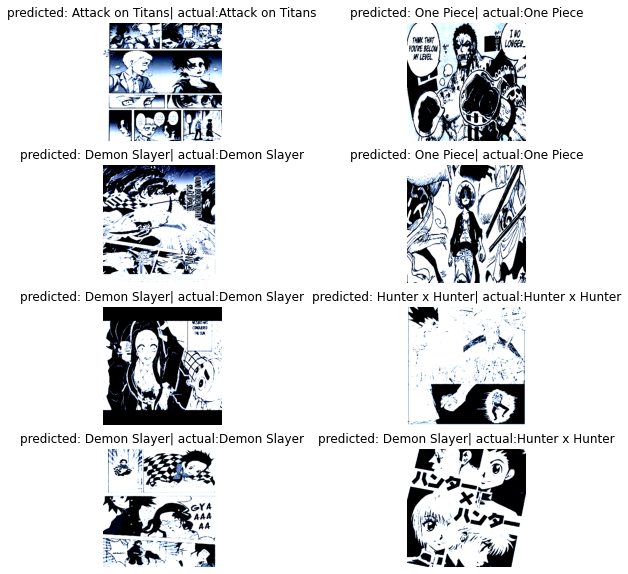

In [51]:
def show_prediction(model , dl, num):
  fig = plt.figure(figsize=(10, 10))
  model.eval()
  with torch.no_grad():
    inputs, labels = next(iter(dl))
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    for i in range(num):
      ax = plt.subplot(num//2, 2, i+1)
      ax.set_title('predicted: {}| actual:{}'.format(classes[preds[i]], classes[labels[i]]))
      ax.axis('off')
      ax.imshow(inputs.cpu()[i].permute(1, 2 ,0))
  model.train()

show_prediction(model, valid_dl, 8) # implement torchvision.utils.make_grid

Let's discuss the image outputs in the function above, specificaly the last image. Although the image is clear and contains the main characters of Hunter x Hunter, our model falsely thinks that the image belongs to the Demon Slayer manga. In order to see where the model made the mistake, we need to understand which parts of the image activated our model the most. In other words, we want to know what parts of the image where most important to our classification model. Pytorch has function called hooks which allow's us to "hook" out a layer in our network. Using this technique we can regirster a hook in our forward pass and extract the last layer of the convolutional part of the network. for more information on why we choose this particular layer refer to Matt Zeiler and Rob Fergus's [Visualizing and Understanding Convolutional Networks](https://arxiv.org/pdf/1311.2901.pdf) paper. In general the deeper the layers the more features our model is able to extract. 

In [74]:
# this will show us the module and the name of a the kth layer
k = 0
for name , module in model.named_modules():
  k+= 1
  if k == 113:
    print(module)
    print('-' * 20)
    print(name)
 

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
--------------------
layer4.2.conv2


In [100]:
img, label = next(iter(valid_dl))
img = img.to(device)

weights= []
def get_layer(module, input, output):
  weights= output

model.layer4[2].conv2.register_forward_hook(get_layer)


out = model(img)

print(weights[0][5].shape) # miscalissified picture 
activated = weights[0][5]

mean_act = activated.mean(0)
print(mean_act.shape)

RuntimeError: ignored

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


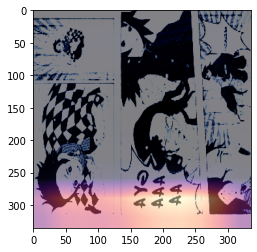

In [103]:
fig , ax = plt.subplots()
ax.imshow(img[6].cpu().permute(2, 1, 0))
ax.imshow(mean_act.cpu().detach(), alpha = 0.5, extent=(0, 335, 335, 0), 
          interpolation = 'bilinear', cmap = 'magma' )
